In [1]:
!pip install xgboost

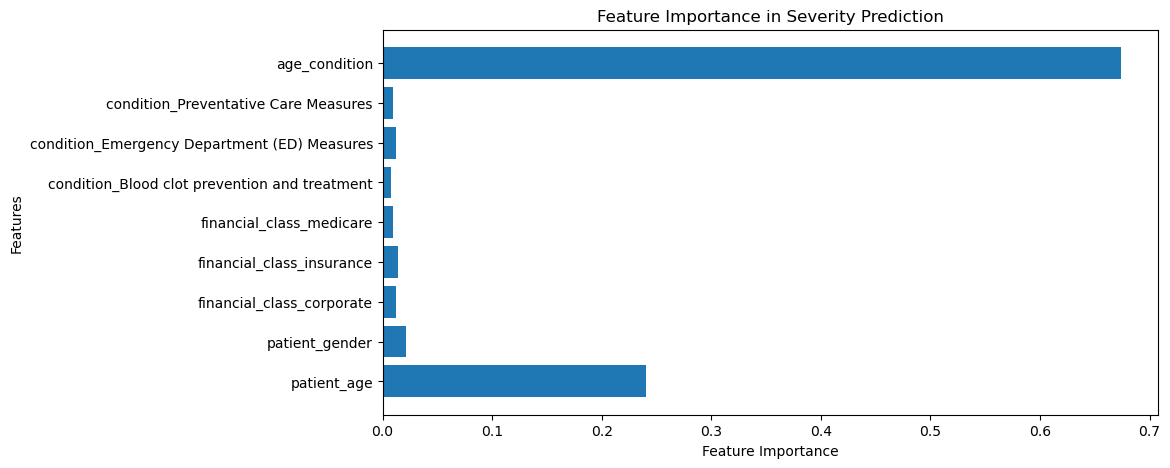

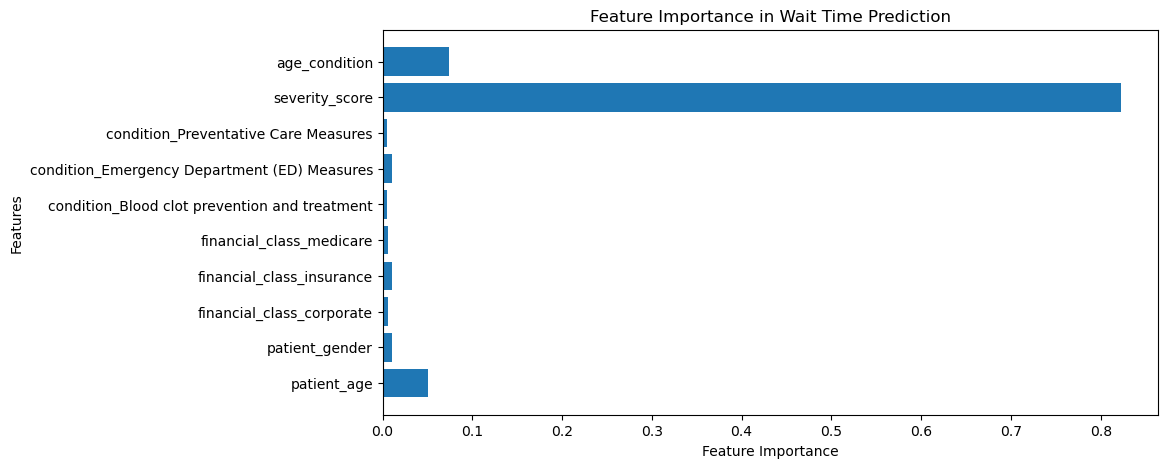

DEBUG: Predicted Severity ➝ [0]
DEBUG: Predicted Wait Time ➝ [3.84333333]
🚀 Patient: John Doe | Condition: Heart Disease | Age: 65 | Severity: 0 | Wait Time: 3.84 mins
DEBUG: Predicted Severity ➝ [0]
DEBUG: Predicted Wait Time ➝ [4.855]
🚀 Patient: Jane Smith | Condition: Diabetes | Age: 45 | Severity: 0 | Wait Time: 4.86 mins
DEBUG: Predicted Severity ➝ [0]
DEBUG: Predicted Wait Time ➝ [7.61]
🚀 Patient: Alice Johnson | Condition: Flu | Age: 30 | Severity: 0 | Wait Time: 7.61 mins
DEBUG: Predicted Severity ➝ [0]
DEBUG: Predicted Wait Time ➝ [4.75]
🚀 Patient: Bob Brown | Condition: Injury | Age: 50 | Severity: 0 | Wait Time: 4.75 mins
Classifier Accuracy: 0.9500
Regressor MAE: 2.9527
Regressor RMSE: 3.4678
Regressor R² Score: 0.7541


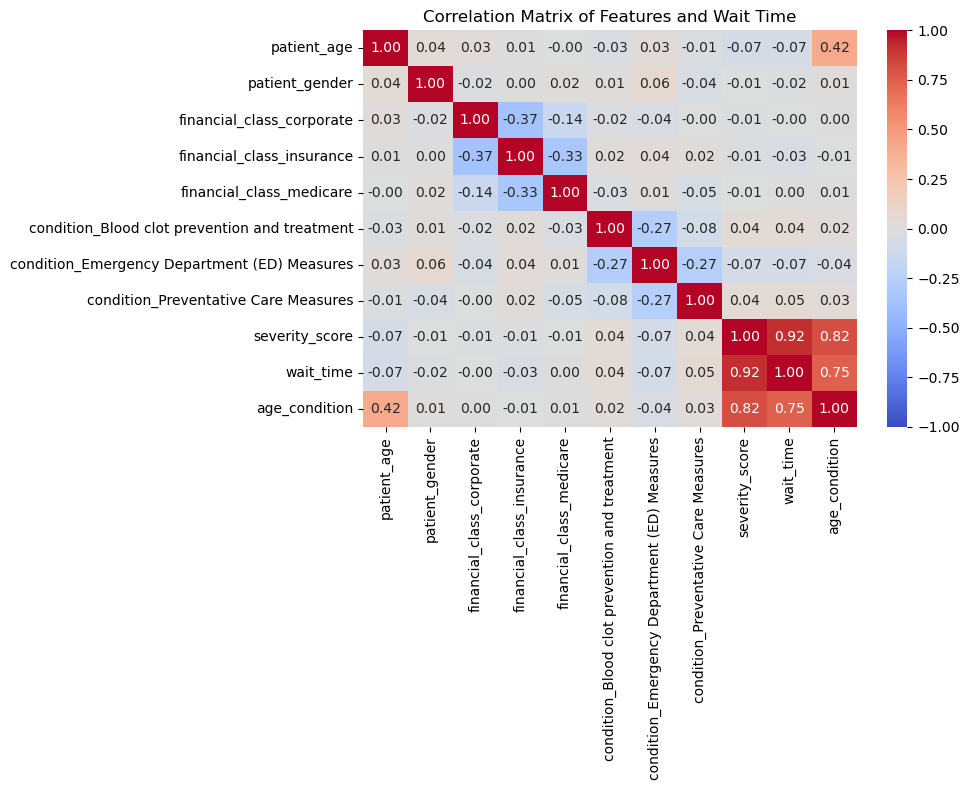

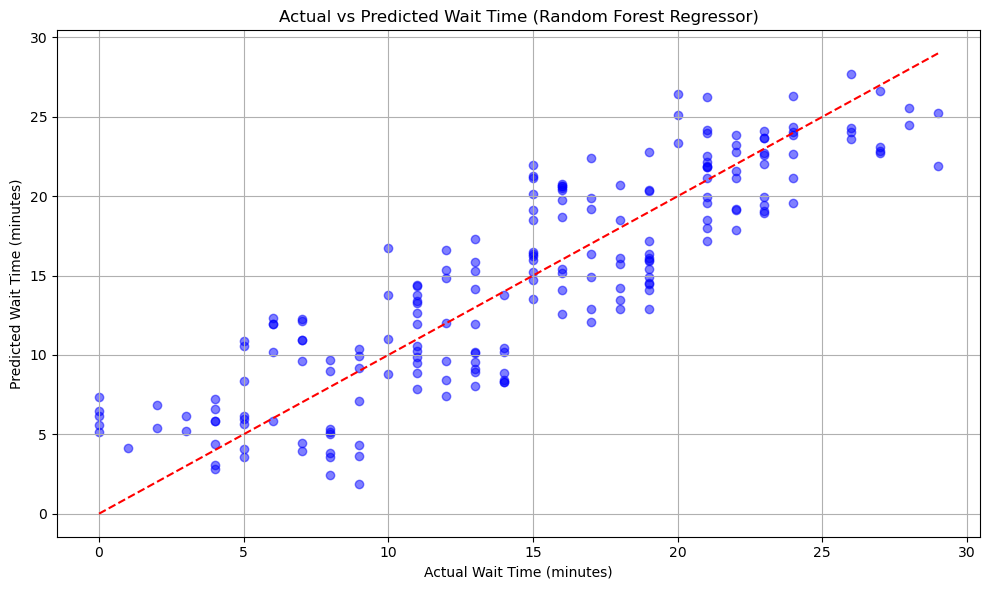

DEBUG: Predicted Severity ➝ [0]
DEBUG: Predicted Wait Time ➝ [3.84333333]
DEBUG: Predicted Severity ➝ [0]
DEBUG: Predicted Wait Time ➝ [4.63367857]
DEBUG: Predicted Severity ➝ [0]
DEBUG: Predicted Wait Time ➝ [5.55]
DEBUG: Predicted Severity ➝ [0]
DEBUG: Predicted Wait Time ➝ [4.75]


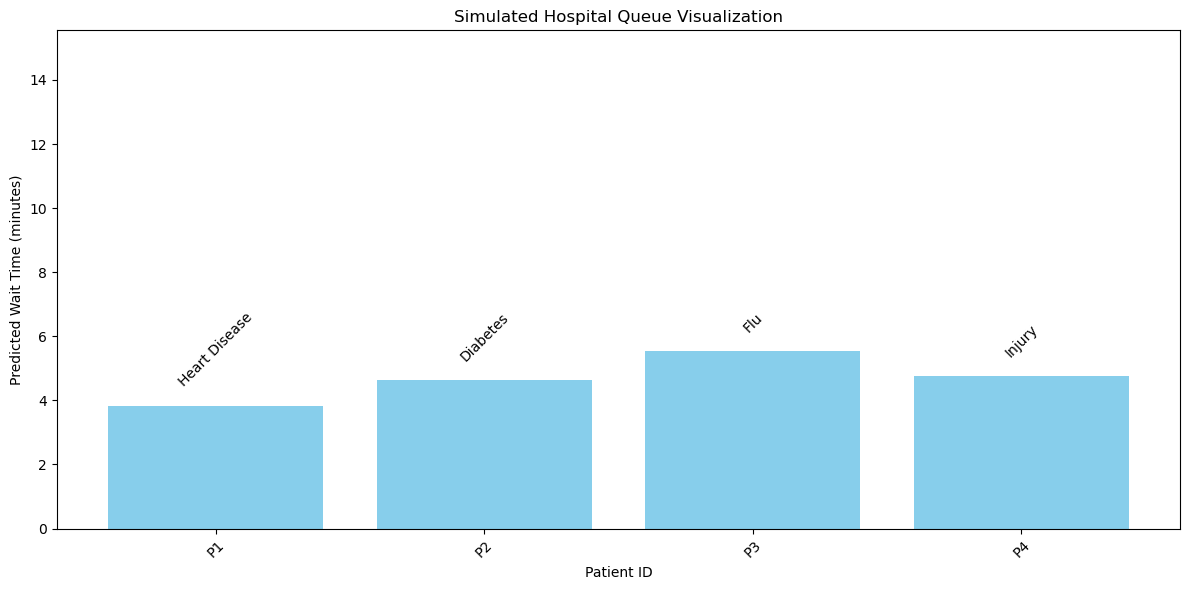


Simulated Queue Details:
  patient_id           name      condition  predicted_wait_time
0         P1       John Doe  Heart Disease                 3.84
1         P2     Jane Smith       Diabetes                 4.63
2         P3  Alice Johnson            Flu                 5.55
3         P4      Bob Brown         Injury                 4.75


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load dataset
file_path = '/Users/reinamercy/wait-time-prediction/dseb/mock_up_patient_data.xlsx'
df = pd.read_excel(file_path)

# Drop irrelevant columns
df.drop(columns=["patient_id", "surname", "entry_time", "post-consultation_time", "completion_time"], errors="ignore", inplace=True)

# Encode categorical variables
df["patient_gender"] = df["patient_gender"].map({"male": 0, "female": 1})
df = pd.get_dummies(df, columns=["financial_class", "condition"], drop_first=True)

# Fill missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Ensure Severity & Wait Time Columns Exist
if "severity_score" not in df.columns:
    df["severity_score"] = np.random.randint(0, 5, size=len(df))
if "wait_time" not in df.columns:
    df["wait_time"] = df["severity_score"] * 5 + np.random.randint(0, 10, size=len(df))

# Feature Engineering
df["age_condition"] = df["patient_age"] * df["severity_score"]

# Split data for classification
X_class = df.drop(columns=["severity_score", "wait_time"])
y_class = df["severity_score"]
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Handle Class Imbalance (SMOTE)
smote = SMOTE(random_state=42)
X_train_class_balanced, y_train_class_balanced = smote.fit_resample(X_train_class, y_train_class)

# Train Classifier
rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
rf_clf.fit(X_train_class_balanced, y_train_class_balanced)
y_pred_class_rf = rf_clf.predict(X_test_class)
class_acc_rf = accuracy_score(y_test_class, y_pred_class_rf)

# Feature Importance (Classification)
plt.figure(figsize=(10, 5))
plt.barh(X_train_class.columns, rf_clf.feature_importances_)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Severity Prediction")
plt.show()

# Split data for regression
X_reg = df.drop(columns=["wait_time"])
y_reg = df["wait_time"]
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train Regressor
rf_reg = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)
y_pred_reg_rf = rf_reg.predict(X_test_reg)

# Regression Metrics
reg_mae_rf = mean_absolute_error(y_test_reg, y_pred_reg_rf)
reg_rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_rf))
reg_r2_rf = r2_score(y_test_reg, y_pred_reg_rf)

# Feature Importance (Regression)
plt.figure(figsize=(10, 5))
plt.barh(X_train_reg.columns, rf_reg.feature_importances_)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Wait Time Prediction")
plt.show()

def process_new_patient(name, condition, age, gender="male"):
    # Convert input to dataframe
    new_patient_df = pd.DataFrame({
        "patient_age": [age],
        "patient_gender": [0 if gender == "male" else 1]
    })
    
    # Add categorical features
    for col in X_class.columns:
        if col.startswith("condition_"):
            new_patient_df[col] = 1 if col == f"condition_{condition}" else 0
        elif col.startswith("financial_class_"):
            new_patient_df[col] = 0  # Default to 0

    # Align columns to match training set for severity prediction
    new_patient_df = new_patient_df.reindex(columns=X_class.columns, fill_value=0)

    # Predict severity
    severity_pred = rf_clf.predict(new_patient_df)
    new_patient_df["severity_score"] = severity_pred

    print(f"DEBUG: Predicted Severity ➝ {severity_pred}")

    # Ensure the feature order matches training before wait time prediction
    new_patient_df = new_patient_df.reindex(columns=X_reg.columns, fill_value=0)

    # Predict wait time
    wait_time_pred = rf_reg.predict(new_patient_df)
    new_patient_df["wait_time"] = wait_time_pred

    print(f"DEBUG: Predicted Wait Time ➝ {wait_time_pred}")

    return f"🚀 Patient: {name} | Condition: {condition} | Age: {age} | Severity: {severity_pred[0]} | Wait Time: {wait_time_pred[0]:.2f} mins"

# Test Cases
print(process_new_patient("John Doe", "Heart Disease", 65))
print(process_new_patient("Jane Smith", "Diabetes", 45))
print(process_new_patient("Alice Johnson", "Flu", 30))
print(process_new_patient("Bob Brown", "Injury", 50))

# Final Model Performance
print(f"Classifier Accuracy: {class_acc_rf:.4f}")
print(f"Regressor MAE: {reg_mae_rf:.4f}")
print(f"Regressor RMSE: {reg_rmse_rf:.4f}")
print(f"Regressor R² Score: {reg_r2_rf:.4f}")

# --- Visualizations ---
# 1. Correlation Matrix
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features and Wait Time')
plt.tight_layout()
plt.show()

# 2. Actual vs Predicted Wait Time Graph
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg_rf, alpha=0.5, color='blue')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], color='red', linestyle='--')
plt.xlabel('Actual Wait Time (minutes)')
plt.ylabel('Predicted Wait Time (minutes)')
plt.title('Actual vs Predicted Wait Time (Random Forest Regressor)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Queue Visualization (Simulated from Test Cases)
queue = [
    {"patient_id": "P1", "name": "John Doe", "condition": "Heart Disease", "age": 65, "gender": "male"},
    {"patient_id": "P2", "name": "Jane Smith", "condition": "Diabetes", "age": 45, "gender": "female"},
    {"patient_id": "P3", "name": "Alice Johnson", "condition": "Flu", "age": 30, "gender": "female"},
    {"patient_id": "P4", "name": "Bob Brown", "condition": "Injury", "age": 50, "gender": "male"}
]

queue_df = pd.DataFrame(queue)
queue_df['predicted_wait_time'] = queue_df.apply(
    lambda row: process_new_patient(row['name'], row['condition'], row['age'], row['gender']).split("Wait Time: ")[1].split(" mins")[0],
    axis=1
)
queue_df['predicted_wait_time'] = queue_df['predicted_wait_time'].astype(float)

plt.figure(figsize=(12, 6))
bars = plt.bar(queue_df['patient_id'], queue_df['predicted_wait_time'], color='skyblue')
for bar, condition in zip(bars, queue_df['condition']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, condition, 
             ha='center', va='bottom', fontsize=10, rotation=45)
plt.xlabel('Patient ID')
plt.ylabel('Predicted Wait Time (minutes)')
plt.title('Simulated Hospital Queue Visualization')
plt.xticks(rotation=45)
plt.ylim(0, max(queue_df['predicted_wait_time']) + 10)
plt.tight_layout()
plt.show()

# Print queue details
print("\nSimulated Queue Details:")
print(queue_df[['patient_id', 'name', 'condition', 'predicted_wait_time']])



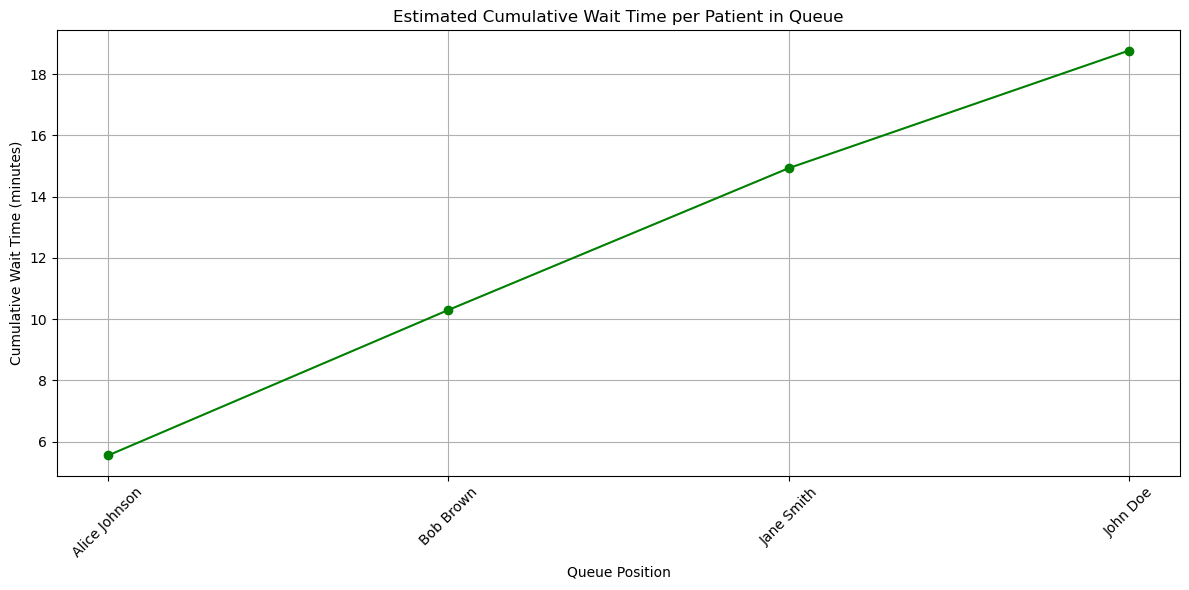

In [14]:
queue_df = queue_df.sort_values(by='predicted_wait_time', ascending=False).reset_index(drop=True)
queue_df['cumulative_wait_time'] = queue_df['predicted_wait_time'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(queue_df.index + 1, queue_df['cumulative_wait_time'], marker='o', linestyle='-', color='green')
plt.xlabel("Queue Position")
plt.ylabel("Cumulative Wait Time (minutes)")
plt.title("Estimated Cumulative Wait Time per Patient in Queue")
plt.xticks(queue_df.index + 1, queue_df['name'], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
